This notebook demonstrates how to perform PCA and extract top components for further analysis. The extracted components are used here to perform Logistic Regression, but you will see that it doesn't generate desired results. Instead of a marginal reduction in model performance, the AUC of the model drops significantly. 

### Import packages

In [1]:
# data processing
import pandas as pd
import numpy as np

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid');

### Set-up

In [2]:
infile = 'https://raw.githubusercontent.com/vishal-git/dapt-631/main/data/credit_default_model_data.csv'

target = 'default payment next month'

### Read data

In [3]:
df = pd.read_csv(infile)

y = df[target]
X = df.drop(target, axis=1)
del df

X.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_8_flag,pay_bucket_-2_flag,pay_bucket_-1_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,group
0,40000,28,10371,11895,11228,2475,5341,6255,2567,0,...,0,0,1,11883,47565,0.249827,0,0.198187,0.297375,M
1,320000,35,12233,16490,20011,17918,18627,19167,7000,4100,...,0,0,0,15100,104446,0.144572,0,0.054399,0.062534,M
2,260000,35,188,188,188,188,194,188,188,188,...,0,0,1,1167,1134,1.029101,0,0.000727,0.000746,M
3,360000,36,308711,305594,306176,304645,315118,315782,11000,13000,...,0,0,0,71322,1856026,0.038427,0,0.859271,0.877172,M
4,500000,25,-46,9412,1260,0,1121,6566,9458,1260,...,0,0,1,20839,18313,1.137935,0,0.006104,0.018824,M


### Train-Test partition

In [4]:
X_train = X[X['group'] == 'M'].drop('group', axis=1)[X.columns[:-1]]
X_test = X[X['group'] == 'T'].drop('group', axis=1)[X.columns[:-1]]

y_train = y[X['group'] == 'M']
y_test = y[X['group'] == 'T']

len(X_train), len(X_test)

(15000, 7500)

### Logistic Regression model

In [5]:
logit = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=314)

Standardize the input data.

In [6]:
X_scaler = StandardScaler()

# fit and transform the training data frame
X_train_std = X_scaler.fit_transform(X_train)

# transform the test data frame
X_test_std = X_scaler.transform(X_test)

[Normalize data before or after split of training and testing data?](https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data)

Fit the model and get model scores.

In [7]:
logit.fit(X_train_std, y_train)

logit_scores_train = logit.predict_proba(X_train_std)[:, 1]
logit_scores_test = logit.predict_proba(X_test_std)[:, 1]

ROC Curve

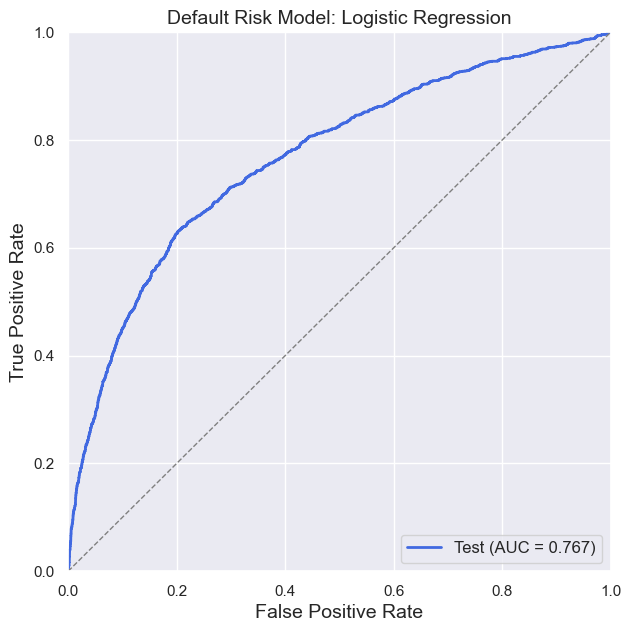

In [8]:
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)
auc_logit = roc_auc_score(y_test, logit_scores_test)

sns.set(style='darkgrid')
plt.figure().set_size_inches(7, 7)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label=f'Test (AUC = {auc_logit:0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logistic Regression', fontsize = 14)
plt.legend(loc="lower right", fontsize = 12);

### Principal Component Analysis (PCA)

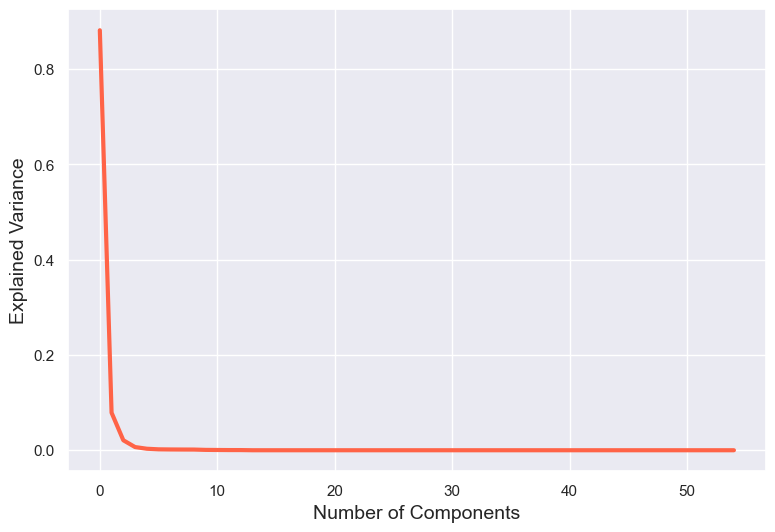

In [9]:
pca = PCA(random_state=314)
pca.fit(X_train)

n_cols = len(X_train.columns)

plt.figure(figsize=(9, 6))
sns.lineplot(x=range(n_cols), 
             y=pca.explained_variance_ratio_, 
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

A very few principal compoents appear to explain most of the variance in the data. This is a red flag.

We need to *standardize* the data before fitting PCA -- i.e., run PCA on standardized data.

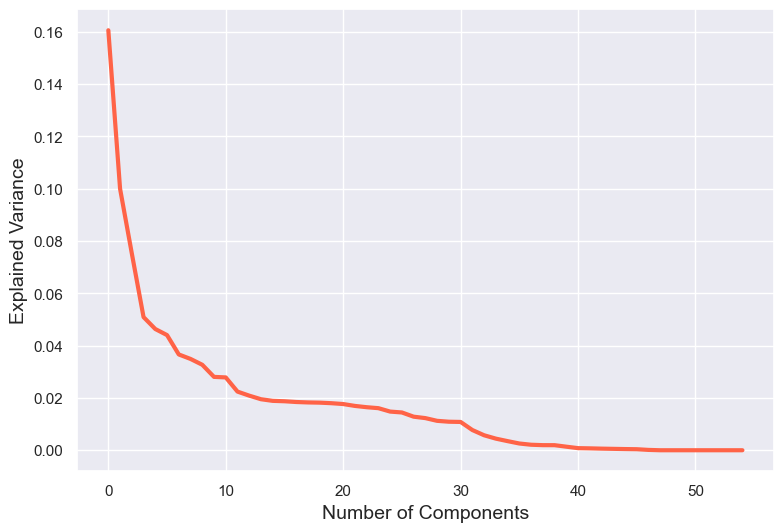

In [10]:
pca.fit(X_train_std)

plt.figure(figsize=(9, 6))

sns.lineplot(x=range(n_cols), 
             y=pca.explained_variance_ratio_, 
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

Cumulative Variance Explained

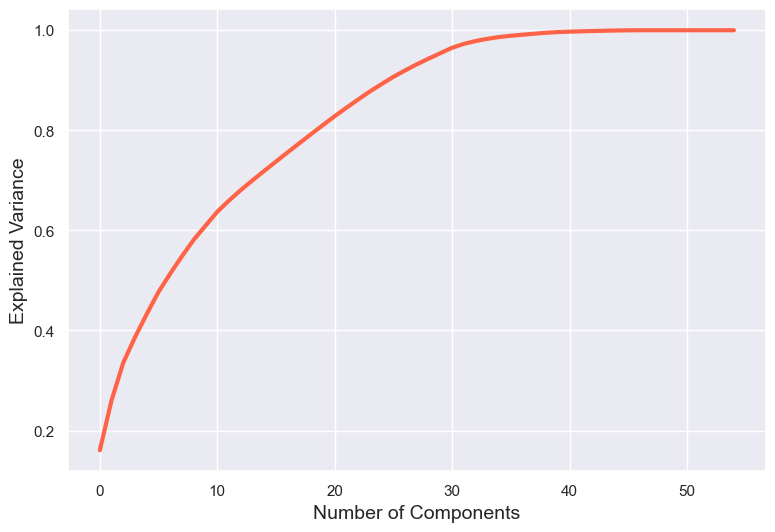

In [11]:
plt.figure(figsize=(9, 6))

sns.lineplot(x=range(n_cols), 
             y=np.cumsum(pca.explained_variance_ratio_),
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

In [12]:
np.cumsum(pca.explained_variance_ratio_)[30]

0.9650021896711285

Let's keep the top 30 principal compoents. By doing so, we will retain 97% of the total variance.

In [13]:
components_to_keep = 30

pca = PCA(n_components=components_to_keep, random_state=314)

In [14]:
pca_X_train = pca.fit_transform(X_train_std)
pca_X_train

array([[-2.40072206,  0.18880751,  0.40352133, ..., -0.9745878 ,
        -0.03881021, -1.15326804],
       [-0.57744135, -0.33496596, -0.60529465, ...,  0.26177601,
        -0.06166702,  0.42322665],
       [-3.00602133, -0.2039867 ,  1.07652221, ..., -0.40835262,
        -0.03764418,  0.69925038],
       ...,
       [ 6.66560862, -0.22793351, -0.52409079, ..., -0.18068252,
        -0.10805123, -0.02257268],
       [-0.6217423 , -0.6740473 ,  1.22463526, ..., -0.55376174,
         0.22684219, -0.96029773],
       [-2.90269472, -0.18435063,  1.24531743, ..., -0.67628344,
        -0.03098142, -0.27727649]])

In [15]:
# fit the model using principal components
pl_fit = logit.fit(pca_X_train, y_train)

# calculate model scores (predicted probabilities)
pl_scores_test = pl_fit.predict_proba(pca.transform(X_test_std))[:, 1]

ROC Curve

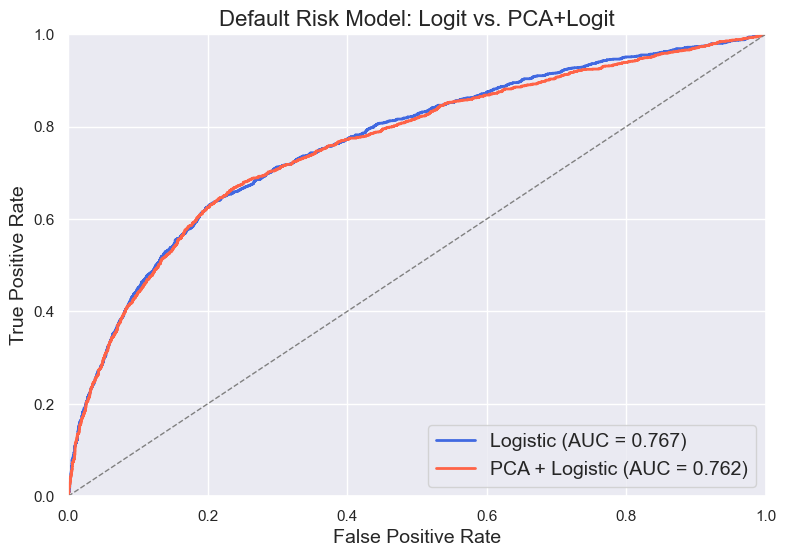

In [16]:
pl_fpr_test, pl_tpr_test, _ = roc_curve(y_test, pl_scores_test)
auc_pl = roc_auc_score(y_test, pl_scores_test)

plt.figure(figsize=(9, 6))

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, 
         label=f'Logistic (AUC = {auc_logit:0.3f})')

plt.plot(pl_fpr_test, pl_tpr_test, color='tomato', lw=2,
         label=f'PCA + Logistic (AUC = {auc_pl:0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logit vs. PCA+Logit', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

Why did the model performance got worse?